# Goal

Pricing optimization is, non surprisingly, another area where data science can provide huge
value.

The goal here is to evaluate whether a pricing test running on the site has been successful.
As always, you should focus on user segmentation and provide insights about segments
who behave differently as well as any other insights you might find

# Challenge Description

Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of
Product has decided to run a test increasing the price. She hopes that this would increase
revenue. In the experiment, 66% of the users have seen the old price ($39), while a random
sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding
how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

* Should the company sell its software for $39 or $59?
* The VP of Product is interested in having a holistic view into user behavior, especially
focusing on actionable insights that might increase conversion rate. What are your main
findings looking at the data?
* [Bonus] The VP of Product feels that the test has been running for too long and he should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain
why

# Data

## test_results
### Columns:
* user_id : the Id of the user. Can be joined to user_id in user_table
* timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
* source : marketing channel that led to the user coming to the site. It can be:
  - ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
  - google ads, yahoo ads, etc.
  - seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
  - google search, yahoo, facebook, etc.
  - friend_referral : user coming from a referral link of another user
* direct_traffic: user coming by directly typing the address of the site on the browser
* device : user device. Can be mobile or web
* operative_system : user operative system. Can be: "windows", "linux", "mac" for web,
and "android", "iOS" for mobile. 	Other	 if it is none of the above
* test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> oldlower
price)
* price : the price the user sees. It should match test
* converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left
the site without buying it)


## user_table

### Columns:

* user_id : the Id of the user. Can be joined to user_id in test_results table
* city : the city where the user is located. Comes from the user ip address
* country : in which country the city is located
* lat : city latitude - should match user city
* long : city longitude - should match user city

In [139]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [89]:
# load the data
user_table = pd.read_csv('user_table.csv')
test_result = pd.read_csv('test_results.csv')

In [47]:
# no null data, no duplicate data for user table
user_table.info()
print('the number of unique user:', len(user_table['user_id'].unique()))
print('the number of country:', len(user_table['country'].unique()))
print('the number of city:', len(user_table['city'].unique()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB
the number of unique user: 275616
the number of country: 1
the number of city: 923


In [50]:
# look at the data
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [51]:
user_table.describe()

,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


In [18]:
test_result.info()
test_result.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [78]:
# some error timestamp data, the second and minute is equal to 60
test_result[test_result.iloc[:,1].str.slice(start =-2).astype('int')>=60]

,user_id,timestamp,source,device,operative_system,test,price,converted
278,287830,2015-04-04 02:23:60,direct_traffic,web,windows,1,59,0
330,765772,2015-03-20 12:20:60,ads-yahoo,web,mac,0,39,0
361,842974,2015-04-10 07:42:60,ads-google,mobile,iOS,1,59,0
383,652221,2015-03-10 12:31:60,friend_referral,mobile,android,0,39,0
422,890062,2015-04-17 12:10:60,ads-bing,mobile,other,0,39,0
...,...,...,...,...,...,...,...,...
316564,497256,2015-03-08 19:06:60,direct_traffic,mobile,iOS,0,39,0
316566,999430,2015-03-21 16:27:60,friend_referral,web,windows,0,39,0
316606,256920,2015-05-29 14:34:60,ads_other,mobile,iOS,1,59,0
316709,177121,2015-03-20 18:33:60,ads_facebook,mobile,iOS,0,39,0


In [79]:
test_result[test_result.iloc[:,1].str.slice(start =-5, stop =-3).astype('int')>=60]


,user_id,timestamp,source,device,operative_system,test,price,converted
54,370914,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0
104,549807,2015-04-24 11:60:20,friend_referral,mobile,iOS,0,39,0
121,107010,2015-03-14 12:60:02,direct_traffic,web,windows,0,39,0
282,676183,2015-05-11 12:60:53,ads-google,web,windows,1,59,0
287,641153,2015-04-26 11:60:44,direct_traffic,mobile,android,0,39,0
...,...,...,...,...,...,...,...,...
316138,212261,2015-04-13 18:60:11,ads_other,mobile,iOS,0,39,0
316517,15556,2015-04-25 14:60:58,ads_other,mobile,android,0,39,0
316525,121009,2015-05-11 12:60:53,ads-google,web,windows,1,59,0
316558,136560,2015-04-10 11:60:29,ads_other,web,windows,1,59,0


In [72]:
test_result[test_result.iloc[:,1].str.slice(start =-8, stop =-6).astype('int')>=24]

,user_id,timestamp,source,device,operative_system,test,price,converted


In [90]:
#replace the 60 with 00 for all data
test_result['timestamp'] = test_result['timestamp'].apply(lambda x: re.sub('60', '00', x))

In [116]:
#change the type of timestamp to datetime
test_result['timestamp'] = pd.to_datetime(test_result['timestamp'])

In [117]:
test_result['date'] = test_result['timestamp'].dt.date

In [118]:
# merge two table
price_test = test_result.merge(user_table, on = 'user_id', how = 'left')

In [97]:
price_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           316800 non-null  int64         
 1   timestamp         316800 non-null  datetime64[ns]
 2   source            316800 non-null  object        
 3   device            316800 non-null  object        
 4   operative_system  316800 non-null  object        
 5   test              316800 non-null  int64         
 6   price             316800 non-null  int64         
 7   converted         316800 non-null  int64         
 8   city              275616 non-null  object        
 9   country           275616 non-null  object        
 10  lat               275616 non-null  float64       
 11  long              275616 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 31.4+ MB


In [119]:
#make sure every user only in one test
user_test = price_test.groupby(['user_id']).count()
user_test[user_test['timestamp']>1]

,timestamp,source,device,operative_system,test,price,converted,date,city,country,lat,long
user_id,,,,,,,,,,,,


In [120]:
# while some user in test 1 but the price they seen is 59 and some user in test 0 but the price they seen is 39.
price_test.groupby(['test','price']).count()
# delete problematic data
price_test.drop(price_test[(price_test['test']==0) & (price_test['price']==59)].index, inplace = True)
price_test.drop(price_test[(price_test['test']==1) & (price_test['price']==39)].index, inplace = True)

<AxesSubplot:xlabel='source', ylabel='count'>

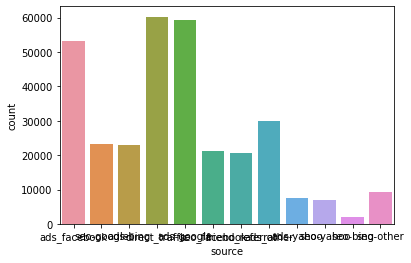

In [124]:
sns.countplot(data = price_test, x= 'source')

<AxesSubplot:xlabel='device', ylabel='count'>

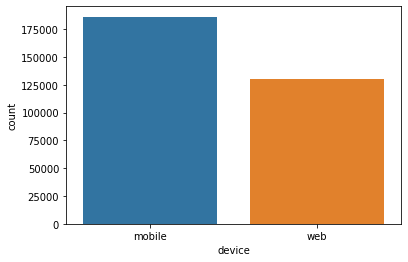

In [125]:
sns.countplot(data = price_test, x = 'device')

<AxesSubplot:xlabel='operative_system', ylabel='count'>

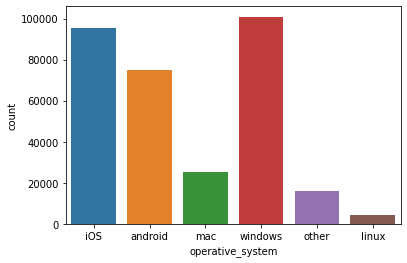

In [126]:
sns.countplot(data = price_test, x = 'operative_system')

Since the conversion can be 0 and 1, we can see the conversion follow the bernoulli distribution. Then the sum of conversion should follow binomial distribution.
The estimated conversion rate should be $\hat{p}$ is the mean of all conversion.

Due to the number of test is over 300,000 we can use two sample t-test to conduct hypothesis test by using the law of large number.

We can set null hypothesis is no difference between test group and control group, alternative hypothesis is the conversion rate in test group is less than control group.
Set the significant level $\alpha = 0.05$.

$H_0: \mu_1= \mu_0$

$H_1: \mu_1< \mu_0$

In [136]:
# separate test and control set
test_group = price_test[price_test['test']==1]['converted']
control_group = price_test[price_test['test'] ==0]['converted']
# see if equal variance
print('variance of test group:', test_group.var())
print('variance of control group:', control_group.var())

variance of test group: 0.015313223261599968
variance of control group: 0.019503667646662493


In [137]:
# see if n is equal
print('the number of user in test group:', test_group.count())
print('the number of user in control group:', control_group.count())

the number of user in test group: 113918
the number of user in control group: 202517


In [149]:
print('the mean of conversion in test group:', test_group.mean())
print('the mean of conversion in control group:', control_group.mean())

the mean of conversion in test group: 0.01555504836812444
the mean of conversion in control group: 0.019899563987220825


In [148]:
#first, conduct two side t test
stats.ttest_ind(test_group, control_group, alternative='less', equal_var = True)

Ttest_indResult(statistic=-8.744781828681587, pvalue=1.1225425800748573e-18)

p-value is less than significant level, that mean we have strong evidence
to say the mean of test group is less than control group.

While the conversion rate in test group is less than control group, the price is higher in test group. Then we can see the
average revenue for each person.

We can set null hypothesis is no difference of revenue between test group and control group, alternative hypothesis is the average revenue in test group is greater than control group.
Set the significant level $\alpha = 0.05$.

$H_0: \mu_1= \mu_0$

$H_1: \mu_1> \mu_0$

In [152]:
revenue_test = price_test[price_test['test']==1]['converted']* 59
revenue_control = price_test[price_test['test']==0]['converted']* 39
# see if equal variance
print('variance of test group:', revenue_test.var())
print('variance of control group:', revenue_control.var())

variance of test group: 53.30533017362951
variance of control group: 29.66507849057365


In [153]:
# see if n is equal
print('the number of user in test group:', revenue_test.count())
print('the number of user in control group:', revenue_control.count())

the number of user in test group: 113918
the number of user in control group: 202517


In [154]:
print('the mean of conversion in test group:', revenue_test.mean())
print('the mean of conversion in control group:', revenue_control.mean())


the mean of conversion in test group: 0.917747853719342
the mean of conversion in control group: 0.7760829955016122
